In [1]:
import pickle
import os
import torch

def load_cifar10_batch(file_path):
    """Load a single CIFAR-10 batch file."""
    with open(file_path, 'rb') as fo:
        batch_dict = pickle.load(fo, encoding='bytes')
    return batch_dict

def load_cifar10_data(data_dir="../data/cifar10/cifar-10-batches-py"):
    """Load CIFAR-10 dataset."""
    
    # Load training data
    train_data = []
    train_labels = []
    
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f"data_batch_{i}")
        batch = load_cifar10_batch(batch_file)
        train_data.append(torch.from_numpy(batch[b'data']))
        train_labels.extend(batch[b'labels'])
    
    # Combine all training batches using torch
    train_data = torch.vstack(train_data)
    train_labels = torch.tensor(train_labels)
    
    # Load test data
    test_batch = load_cifar10_batch(os.path.join(data_dir, "test_batch"))
    test_data = torch.from_numpy(test_batch[b'data'])
    test_labels = torch.tensor(test_batch[b'labels'])
    
    # Load class names
    meta_file = os.path.join(data_dir, "batches.meta")
    with open(meta_file, 'rb') as fo:
        meta_dict = pickle.load(fo, encoding='bytes')
        class_names = [name.decode('utf-8') for name in meta_dict[b'label_names']]
    
    return (train_data, train_labels), (test_data, test_labels), class_names

def cifar10_to_image(data_array):
    """Convert CIFAR-10 data array to image format (32x32x3)."""
    # CIFAR-10 data is stored as (3072,) -> reshape to (32, 32, 3)
    # Data is in format [R1,R2,...,R1024, G1,G2,...,G1024, B1,B2,...,B1024]
    if isinstance(data_array, torch.Tensor):
        img = data_array.view(3, 32, 32).permute(1, 2, 0)
    else:
        # Convert numpy to torch first
        data_tensor = torch.from_numpy(data_array)
        img = data_tensor.view(3, 32, 32).permute(1, 2, 0)
    return img

# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(train_data, train_labels), (test_data, test_labels), class_names = load_cifar10_data()

print(f"Training data shape: {train_data.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Classes: {class_names}")
print(f"Data type: {train_data.dtype}")
print(f"Value range: [{train_data.min()}, {train_data.max()}]")

Loading CIFAR-10 dataset...
Training data shape: torch.Size([50000, 3072])
Training labels shape: torch.Size([50000])
Test data shape: torch.Size([10000, 3072])
Test labels shape: torch.Size([10000])
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Data type: torch.uint8
Value range: [0, 255]


Visualizing CIFAR-10 training samples:


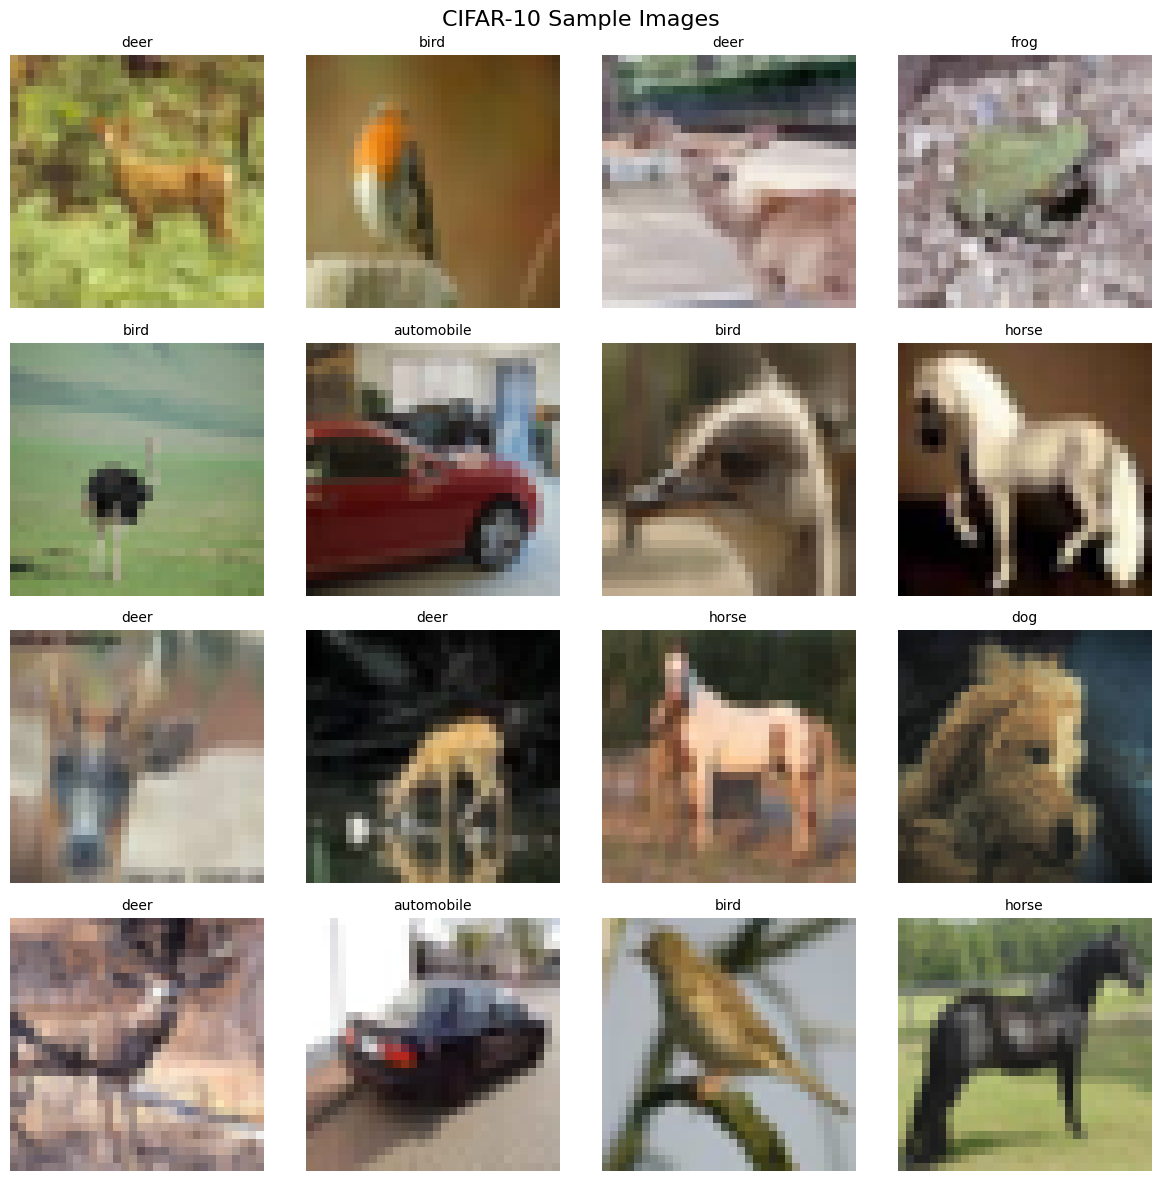

In [2]:
from matplotlib import pyplot as plt

# Visualize some CIFAR-10 samples
def visualize_cifar10_samples(data, labels, class_names, num_samples=16):
    """Visualize random CIFAR-10 samples."""
    
    # Select random samples using torch
    indices = torch.randperm(len(data))[:num_samples]
    
    # Create subplot grid
    rows = int(num_samples**0.5)
    cols = num_samples // rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    fig.suptitle('CIFAR-10 Sample Images', fontsize=16)
    
    for i, idx in enumerate(indices):
        row = i // cols
        col = i % cols
        
        # Convert to image and normalize
        img = cifar10_to_image(data[idx])
        img_normalized = img.float() / 255.0  # Normalize to [0, 1] using torch
        
        # Convert to numpy only for matplotlib display
        axes[row, col].imshow(img_normalized.detach().numpy())
        axes[row, col].set_title(f'{class_names[labels[idx].item()]}', fontsize=10)
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Visualizing CIFAR-10 training samples:")
visualize_cifar10_samples(train_data, train_labels, class_names, num_samples=16)

In [3]:
# Convert CIFAR-10 data to torch tensors for ViT processing
def prepare_cifar10_for_vit(data, labels, normalize=True):
    """Convert CIFAR-10 data to torch tensors suitable for ViT."""
    
    # Ensure inputs are torch tensors
    data_tensor = data if isinstance(data, torch.Tensor) else torch.from_numpy(data)
    labels_tensor = labels if isinstance(labels, torch.Tensor) else torch.from_numpy(labels)
    
    # Convert data to images and normalize using torch operations
    batch_size = data_tensor.shape[0]
    # Reshape from (batch, 3072) to (batch, 3, 32, 32) then to (batch, 32, 32, 3)
    images = data_tensor.view(batch_size, 3, 32, 32).permute(0, 2, 3, 1).float()
    
    if normalize:
        images = images / 255.0  # Normalize to [0, 1]
    
    labels_tensor = labels_tensor.long()
    
    return images, labels_tensor

# Prepare CIFAR-10 data for ViT
print("Converting CIFAR-10 data to torch tensors...")
train_images, train_labels_tensor = prepare_cifar10_for_vit(train_data, train_labels)  # Use subset for demo
test_images, test_labels_tensor = prepare_cifar10_for_vit(test_data, test_labels)  # Use subset for demo

print(f"Training images tensor shape: {train_images.shape}")
print(f"Training labels tensor shape: {train_labels_tensor.shape}")
print(f"Test images tensor shape: {test_images.shape}")
print(f"Test labels tensor shape: {test_labels_tensor.shape}")
print(f"Image data type: {train_images.dtype}")
print(f"Labels data type: {train_labels_tensor.dtype}")
print(f"Image value range: [{train_images.min():.3f}, {train_images.max():.3f}]")

Converting CIFAR-10 data to torch tensors...
Training images tensor shape: torch.Size([50000, 32, 32, 3])
Training labels tensor shape: torch.Size([50000])
Test images tensor shape: torch.Size([10000, 32, 32, 3])
Test labels tensor shape: torch.Size([10000])
Image data type: torch.float32
Labels data type: torch.int64
Image value range: [0.000, 1.000]


Extracting 4x4 patches from CIFAR-10 images...
Original images shape: torch.Size([4, 32, 32, 3])
Patches shape: torch.Size([4, 64, 4, 4, 3])
Number of patches per image: 64
Patch grid: 8x8


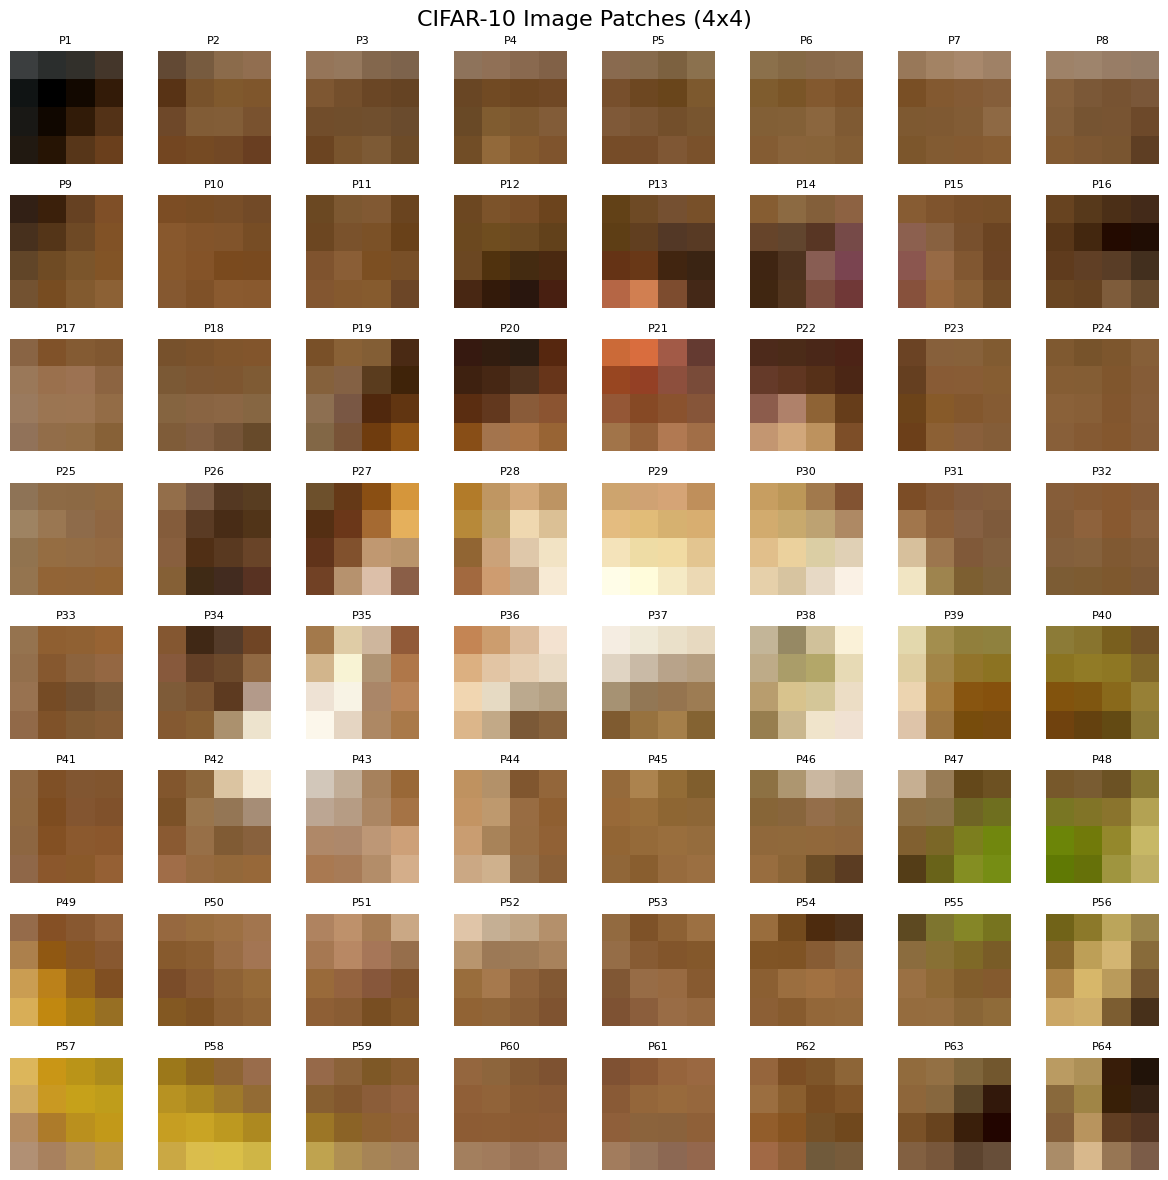

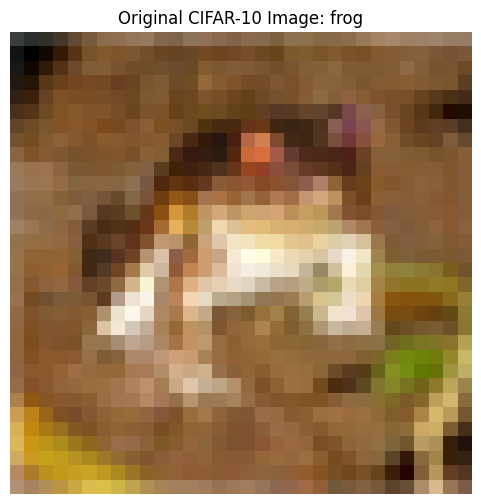

In [4]:
from experiments.model.vit import patch_image

# Apply patch extraction to CIFAR-10 images
def extract_patches_from_cifar10(images, patch_size=4):
    """Extract patches from CIFAR-10 images for ViT processing."""
    
    batch_size, H, W, C = images.shape
    patches_per_image = (H // patch_size) * (W // patch_size)
    
    all_patches = []
    
    for i in range(batch_size):
        # Use the torch_patch_image function we defined earlier
        patches, n_h, n_w = patch_image(images[i], patch_size)
        all_patches.append(patches)
    
    # Stack all patches using torch
    all_patches = torch.stack(all_patches)  # Shape: (batch_size, num_patches, patch_size, patch_size, C)
    
    return all_patches, n_h, n_w

# Extract patches from a sample of CIFAR-10 images
sample_images = train_images[:4]  # Take 4 sample images
patch_size = 4  # 4x4 patches for 32x32 images = 8x8 = 64 patches per image

print(f"Extracting {patch_size}x{patch_size} patches from CIFAR-10 images...")
patches, num_patches_h, num_patches_w = extract_patches_from_cifar10(sample_images, patch_size)

print(f"Original images shape: {sample_images.shape}")
print(f"Patches shape: {patches.shape}")
print(f"Number of patches per image: {patches.shape[1]}")
print(f"Patch grid: {num_patches_h}x{num_patches_w}")

# Visualize patches from the first image using torch operations
fig, axes = plt.subplots(num_patches_h, num_patches_w, figsize=(12, 12))
fig.suptitle(f'CIFAR-10 Image Patches ({patch_size}x{patch_size})', fontsize=16)

first_image_patches = patches[0]  # Take patches from first image

for i in range(first_image_patches.shape[0]):
    row = i // num_patches_w
    col = i % num_patches_w
    
    # Use .detach().numpy() for matplotlib display
    axes[row, col].imshow(first_image_patches[i].detach().numpy())
    axes[row, col].set_title(f'P{i+1}', fontsize=8)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Show the original image for comparison
plt.figure(figsize=(6, 6))
plt.imshow(sample_images[0].detach().numpy())
plt.title(f'Original CIFAR-10 Image: {class_names[train_labels_tensor[0].item()]}')
plt.axis('off')
plt.show()

In [5]:
train_images[0].shape, patch_image(train_images[0], patch_size)[0].shape

(torch.Size([32, 32, 3]), torch.Size([64, 4, 4, 3]))

In [6]:
train_images.permute(0, -1, 1, 2).shape

torch.Size([50000, 3, 32, 32])

In [13]:
patch_size = 16
batch_size = 32
CHANNEL_NUM = 3
H, W = 32, 32

dim_in = CHANNEL_NUM * patch_size * patch_size

train_img_seq = train_images[:batch_size].unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
train_img_seq = train_img_seq.reshape(batch_size, (H // patch_size) * (W // patch_size), dim_in)
train_img_seq.shape

torch.Size([32, 4, 768])

In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from experiments.model.transformer import TransformerEncoder
import math

torch.cuda.empty_cache()
encoder = TransformerEncoder(
    dim_in=dim_in,
    dim_qk=768,
    dim_v=dim_in,
    num_heads=12,
    num_layers=12
)

# Create a simple classification head for the encoder
class ViTClassifier(nn.Module):
    def __init__(self, encoder, num_classes=10, max_seq_len=1000):
        super().__init__()
        self.encoder = encoder
        self.max_seq_len = max_seq_len
        # Add a classification head
        self.classifier = nn.LazyLinear(num_classes)
        
        # Initialize positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(max_seq_len, dim_in) * 0.02)
        
    def forward(self, x):
        # x shape: (batch_size, num_patches, patch_dim)
        batch_size, seq_len, patch_dim = x.shape
        
        # Add CLS token (using mean of patches as CLS token)
        cls_token = x.mean(1, keepdim=True)  # (batch_size, 1, patch_dim)
        x_with_cls = torch.concat([cls_token, x], dim=1)  # (batch_size, seq_len+1, patch_dim)
        
        # Add positional encoding
        seq_len_with_cls = x_with_cls.shape[1]
        if seq_len_with_cls <= self.max_seq_len:
            pos_enc = self.pos_encoding[:seq_len_with_cls].unsqueeze(0)  # (1, seq_len+1, patch_dim)
            x_with_pos = x_with_cls + pos_enc  # (batch_size, seq_len+1, patch_dim)
        else:
            # Handle sequences longer than max_seq_len
            pos_enc = self.pos_encoding.unsqueeze(0)  # (1, max_seq_len, patch_dim)
            x_with_pos = x_with_cls[:, :self.max_seq_len] + pos_enc
        
        # Pass through transformer encoder
        encoded = self.encoder(x_with_pos)  # (batch_size, seq_len+1, patch_dim)
        
        # Use CLS token for classification
        return self.classifier(encoded[:, 0])

# Initialize the complete model
model = ViTClassifier(encoder, num_classes=10)

# Move to GPU if available
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Training on device: {device}")

# Prepare full datasets
print("Preparing full datasets...")
train_img_seq_full = train_images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
train_img_seq_full = train_img_seq_full.reshape(train_images.shape[0], (H // patch_size) * (W // patch_size), dim_in)

test_img_seq_full = test_images.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)  
test_img_seq_full = test_img_seq_full.reshape(test_images.shape[0], (H // patch_size) * (W // patch_size), dim_in)

# Create data loaders
train_dataset = TensorDataset(train_img_seq_full, train_labels_tensor)
test_dataset = TensorDataset(test_img_seq_full, test_labels_tensor)

batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training on device: cuda:1
Preparing full datasets...
Training samples: 50000
Test samples: 10000
Training batches: 98
Test batches: 20


In [15]:
# Training configuration
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training and validation function
def validate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    val_accuracy = 100. * correct / total
    val_loss = val_loss / len(val_loader)
    return val_loss, val_accuracy

# Training loop
num_epochs = 1000
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training progress bar
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
    
    for batch_idx, (inputs, targets) in enumerate(train_pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        train_pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%'
        })
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Validation
    val_loss, val_accuracy = validate_model(model, test_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch results
    print(f'Epoch {epoch+1:2d}/{num_epochs} | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}% | '
          f'LR: {scheduler.get_last_lr()[0]:.6f}')

print("=" * 60)
print("Training completed!")

Starting training...


KeyboardInterrupt: 

In [ ]:
# Final test evaluation
print("Performing final test evaluation...")
print("=" * 40)

model.eval()
test_loss = 0.0
correct = 0
total = 0
class_correct = [0] * 10
class_total = [0] * 10

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc='Testing', leave=False)
    for inputs, targets in test_pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Per-class accuracy
        for i in range(targets.size(0)):
            label = targets[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1
        
        test_pbar.set_postfix({'Acc': f'{100.*correct/total:.2f}%'})

final_test_loss = test_loss / len(test_loader)
final_test_accuracy = 100. * correct / total

print(f'Final Test Results:')
print(f'  Test Loss: {final_test_loss:.4f}')
print(f'  Test Accuracy: {final_test_accuracy:.2f}% ({correct}/{total})')
print()

# Per-class accuracy
print('Per-class Test Accuracy:')
for i in range(10):
    if class_total[i] > 0:
        class_acc = 100. * class_correct[i] / class_total[i]
        print(f'  {class_names[i]:>10}: {class_acc:.2f}% ({class_correct[i]:2d}/{class_total[i]:2d})')
    else:
        print(f'  {class_names[i]:>10}: No samples')

print("=" * 40)

In [ ]:
# Plot training curves
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
ax1.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
ax1.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(range(1, num_epochs + 1), train_accuracies, 'b-', label='Train Accuracy', linewidth=2)
ax2.plot(range(1, num_epochs + 1), val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Training Summary:")
print(f"Best Validation Accuracy: {max(val_accuracies):.2f}% (Epoch {val_accuracies.index(max(val_accuracies)) + 1})")
print(f"Final Train Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {final_test_accuracy:.2f}%")